Dòng sản phẩm: dây đeo thay thế dùng cho 'Apple watch kích thước 38mm/42mm': 
<img src="apple_42_38.jpg">



Danh sách các sản phẩm:
- [Asin: B07CL119KV] iGK Sport Band Compatible for Apple Watch 42mm 38mm, Soft Silicone Sport Strap Replacement Bands Compatible for iWatch Apple Watch Series 3, Series 2, Series 1 S/M M/L <img src=".\productPicture\iGK.png">
- [Asin: B077VLBBYT] Yunsea Compatible for Apple Watch Band 38mm 42mm, Soft Nylon Sport Loop, with Hook and Loop Fastener, Replacement Band Compatible for iWatch Series 1/2/3 <img src=".\productPicture\yunsea.png">
- [Asin: B0786QKGX3] VATI Replacement Band Compatible for Apple Watch Band 38mm 42mm Soft Breathable Nylon Sport Loop Band Adjustable Wrist Strap Replacement Band Compatible for iWatch Series 3/2/1,Sport,Nike+,Edition <img src=".\productPicture\vati.png">
- [Asin: B07BQWGVDX] OULEDI Compatible Stainless Steel Band for Apple Watch Replacement Mesh Strap Bracelet for iWatch Series 1 Series 2 Series 3 Series 4 with Magnetic Closure Clasp 38mm 40mm Rose Gold <img src=".\productPicture\ouledi.png">
- [Asin: B07GTG8FM3] iYou Sport Band Compatible for Apple Watch Band 38MM 42MM, Soft Silicone Replacement Sport Strap Compatible for iWatch 2017 Apple Watch Series 3/2/1, Edition, Nike+, All Models More Colors Choose <img src=".\productPicture\iyou.png">
- [Asin: B075R4NNPH] Waterproof Apple Watch Case 38mm Series 3 & 2 with Premium Soft Silicone Apple Watch Band by Catalyst, Shock Proof Impact Resistant (not Compatible with The 42mm iWatch) <img src=".\productPicture\Waterproof.png">
- [Asin: B079NJY3QL] Catalyst Apple Watch Case 38mm Series 3 & Series 2 Drop Proof Shock Proof Impact Protection Apple Watch case [Rugged iWatch Protective case], Army Green <img src=".\productPicture\Catalyst.png">
- [Asin: B077NCMCR6] For Apple Watch Band 38mm, Maxjoy Nylon iWatch Strap Replacement Bands with Stainless Metal Clasp for Apple Watch Series 3 Series 2 Series 1 Sport and Edition, Army Green <img src=".\productPicture\Maxjoy.png">
- [Asin: B071FK7GS6] Compatible Apple Watch Band 38mm Case, Camyse Shockproof Rugged Protective Cover with Bands Stainless Steel Clasp for iWatch Apple Watch Series 3, 2, 1 Sport Edition for Men Women grils boys - Black <img src=".\productPicture\Camyse.png">

In [11]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# các thư viện sử dụng
from lxml import html  
import json
import requests
import re
import inflect

#vẽ dữ liệu
import matplotlib.pyplot as plt

import pandas as pd

from dateutil import parser as dateparser
from time import sleep
from bs4 import BeautifulSoup

#remove stop word
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 


# stemming
# PorterStemmer để steming
# WordNetLematizer để chuyển đổi từ loại
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
#from nltk.stem.snowball import SnowballStemmer

# tranform vector su dugn tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.cross_validation import train_test_split
# model training
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_auc_score

# download data of nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('sentiwordnet')
## n - NOUN 
## v - VERB 
## a - ADJECTIVE 
## s - ADJECTIVE SATELLITE 
## r - ADVERB 

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')


In [2]:
def ParseReviews(asin):
    #This script has only been tested with Amazon.com
    amazon_url  = 'http://www.amazon.com/product-reviews/'+asin
    # Add some recent user agent to prevent amazon from blocking the request 
    # Find some chrome user agent strings  here https://udger.com/resources/ua-list/browser-detail?browser=Chrome
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/62.0.3202.94 Safari/537.36'}

    for i in range(3):

        response = requests.get(amazon_url,headers = headers,verify=False)
        if response.status_code==404:
            return {"url":amazon_url,"error":"page not found"}
        if response.status_code!=200:
            continue

        '''
        The HTML xpath parser from lxml.etree seems to have max depth limit. 
        It won't traverse further to parse the text if the depth exceeds 254. 
        To avoid this, splitting the html into chunks
        '''
        # chuyển thành cây
        tree = html.fromstring(response.text)
        # gán xpath
        xpath_pageNext = '//li[@data-reftag="cm_cr_arp_d_paging_btm"]'

        # tiến hành lấy thông tin link các trang
        ls_page = tree.xpath(xpath_pageNext)
        
        ## lấy được các trang rồi thì break ngắt vong lập
        break
    
    # lấy tất cả các link trang chứa reviews
    # links
    links = []
    # lấ số lượng trang reviews
    s = ls_page[4].find('a').get('href')
    num_page = int(ls_page[4].find('a').get('href').split('&pageNumber=')[1])
    for i in range(2, num_page + 1):
        url = 'https://amazon.com/' + re.sub(r'ref=cm_cr_arp_d_paging_btm_.*?ie=UTF8&pageNumber=.*$', 'ref=cm_cr_arp_d_paging_btm_' + str(i) + '?ie=UTF8&pageNumber=' +  str(i), s)
        links.append(url)
    
    # lấy reviews ở trang hiện tại
    xpath_reviewsList = '//div[@id="cm_cr-review_list"]'
    xpath_review = '//div[@data-hook="review"]'
    
    review_str = tree.xpath(xpath_reviewsList)
    
    for i in review_str:
        # lấy từng chuỗi review
        reviews = i.xpath(xpath_review)
    
    ## cấu trúc lưu dữ liệu là 1 dic.
    reviews_list = []
    
    ## parse từng chuỗi review:
    for review in reviews:
        
        ls_div = review.find('div').findall('div')
        #### chỉ lấy 4 div đầu tiên theo thứ tự bên dưới
        ### lấy tên
        if ls_div[0].find('a') is None:
                continue
        name = ls_div[0].find('a').findall('div', {'class': 'a-profile-content'})#.findall('div')
        name1 = name[1].find('span', {'class': 'a-profile-avatar-wrapper'}).text
        
        ### đầu tiên là lấy số sao
        star = ls_div[1].find('a').find('i').find('span').text.replace(' out of 5 stars', '')
        ### tiếp theo lấy thời gian
        date = review.find('div').find('span').text
        ### tiếp theo lấy text
        review_content = ls_div[3].find('span').text
        
        ### tiến hành lưu dữ liệu ### tất cả review được chuyển về lower case
        if review_content is not None:
            dic_review = {
                'review_author' : name1,
                'review_rating' : star,
                'review_posted_date' : date,
                'review_text' : review_content.lower()
            }
            reviews_list.append(dic_review)
        

    # lấy reviews trong các trang còn lại
    for link in links:
        response = requests.get(link,headers = headers,verify=False)
        
        # chuyển thành cây
        tree = html.fromstring(response.text)
        
        # tiến hành lấy dữ liệu như trên
        review_str = tree.xpath(xpath_reviewsList)
    
        for i in review_str:
            # lấy từng chuỗi review
            reviews = i.xpath(xpath_review)
        
        ## parse từng chuỗi review:
        for review in reviews:

            ls_div = review.find('div').findall('div')
            #### chỉ lấy 4 div đầu tiên theo thứ tự bên dưới
            ### lấy tên
            if ls_div[0].find('a') is None:
                continue
            name = ls_div[0].find('a').findall('div', {'class': 'a-profile-content'})#.findall('div')
            name1 = name[1].find('span', {'class': 'a-profile-avatar-wrapper'}).text

            ### đầu tiên là lấy số sao
            star = ls_div[1].find('a').find('i').find('span').text.replace(' out of 5 stars', '')
            ### tiếp theo lấy thời gian
            date = review.find('div').find('span').text
            ### tiếp theo lấy text
            review_content = ls_div[3].find('span').text
            
            ### tiến hành lưu dữ liệu ### tất cả review được chuyển về lower case
            if review_content is not None:
                dic_review = {
                    'review_author' : name1,
                    'review_rating' : star,
                    'review_posted_date' : date,
                    'review_text' : review_content.lower()
                }
                reviews_list.append(dic_review)
            
    return reviews_list

In [3]:
def ReadAsin(input):
    AsinList = ['B01MS9O4JC', 'B015WKAQ1K', 'B07C44LMVQ', 'B07CSYNZMG', 'B07C68N8F4', 'B018ONN290', 'B01B61NLU2', 'B01NAWBGQH', 'B01AIH23QS', 'B01M2YQ73M', 'B07B9SLGLK', 'B075R4NNPH', 'B077NCMCR6', 'B071FK7GS6', 'B07CL119KV', 'B077VLBBYT', 'B0786QKGX3', 'B07BQWGVDX', 'B07C44LMVP']
    extracted_data = []
    for asin in AsinList:
        print("Downloading and processing page http://www.amazon.com/product-reviews/"+asin)
        reviews = ParseReviews(asin)
        reviews_len = len(reviews)
        dic = {
            'asin' : asin,
            'reviews count' : reviews_len,
            'reviews' : reviews
        }
        extracted_data.append(dic)
        sleep(5)
    with open(input, "w", encoding="utf-8") as f:
    #   f.write(extracted_data)
    #f = open('DuLieuTho.json','w')
        json.dump(extracted_data,f,indent=4)


### đọc dữ liệu lên và tiền xử lí

loại bỏ stopwords

ngắt câu

---

file input: blabla_data.json

file output: preProcData.json

In [4]:
def removeStopWords(review):
    # khởi tạo 1 set stop word
    stop_words = set(stopwords.words('english')) 
    # tách câu thành tokens  
    word_tokens = word_tokenize(review)
    filtered_sentence = word_tokens
    # tra từng tokens trong set stopword và lưu phần còn lại vào lại câu
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    # tiến hành stemming từng từ trong câu
    #filtered_sentence = [(WordNetLemmatizer().lemmatize(filtered_sentence[i],pos = 'v') if WordNetLemmatizer().lemmatize(filtered_sentence[i]).endswith('e' or 's' or 'ss' or 'sess') else PorterStemmer().stem(filtered_sentence[i])) for i in range(len(filtered_sentence))]
    #filtered_sentence = [PorterStemmer().stem(filtered_sentence[i]) for i in range(len(filtered_sentence))]
    filtered_sentence = [WordNetLemmatizer().lemmatize(filtered_sentence[i],pos = 'v') for i in range(len(filtered_sentence))]
    # tiến hành convert số thành chữ tương ứng với số
    filtered_sentence = [(inflect.engine().number_to_words(filtered_sentence[i]) if filtered_sentence[i].isdigit() else filtered_sentence[i]) for i in range(len(filtered_sentence))]
    # trả về
    re_review = ' '.join(filtered_sentence)
    return re_review

In [5]:
def preProcReviews( input, outputJson):
    # đọc file và load dữ liệu
    f = open(input,'r')
    data_jsons = json.loads(f.read())
    f.close()
    
    num_pd = len(data_jsons)
    for i_pd in range(num_pd):
        num_reviews = len((data_jsons[i_pd])['reviews'])
        for i_rv in range(num_reviews):
            # chuyển start thành số
            data_jsons[i_pd]['reviews'][i_rv]['review_rating'] = float(data_jsons[i_pd]['reviews'][i_rv]['review_rating'])
            '''
            # tiến hành tách câu sử dụng pickle của nltk
            data_jsons[i_pd]['reviews'][i_rv]['review_text'] = tokenizer.tokenize(data_jsons[i_pd]['reviews'][i_rv]['review_text'], realign_boundaries=True)
            #tiến hành tách từ và loại bỏ stopwords trong mỗi câu đồng thời stemming trong từng câu
            num_sentences = len(data_jsons[i_pd]['reviews'][i_rv]['review_text'])
            for sentence in range(num_sentences):
                data_jsons[i_pd]['reviews'][i_rv]['review_text'][sentence] = removeStopWords(data_jsons[i_pd]['reviews'][i_rv]['review_text'][sentence])
                # tiến hành loại bỏ dấu câu
                data_jsons[i_pd]['reviews'][i_rv]['review_text'][sentence] = re.sub(r'[^a-zA-Z0-9 ]',r'',data_jsons[i_pd]['reviews'][i_rv]['review_text'][sentence])
                # tiến hành loại bỏ tất cả các khoảng trắng dư thừa trong câu
                data_jsons[i_pd]['reviews'][i_rv]['review_text'][sentence] = (re.sub(' +', ' ', data_jsons[i_pd]['reviews'][i_rv]['review_text'][sentence])).strip()
                raw = ''.join(data_jsons[i_pd]['reviews'][i_rv]['review_text'][sentence])
            '''
            # remove stop word
            data_jsons[i_pd]['reviews'][i_rv]['review_text'] = removeStopWords(data_jsons[i_pd]['reviews'][i_rv]['review_text'])
            # loại bỏ dấu câu
            data_jsons[i_pd]['reviews'][i_rv]['review_text'] = re.sub(r'[^a-zA-Z0-9 ]',r'',data_jsons[i_pd]['reviews'][i_rv]['review_text'])
            #loại bỏ khoảng trắng dư thừa
            data_jsons[i_pd]['reviews'][i_rv]['review_text'] = (re.sub(' +', ' ', data_jsons[i_pd]['reviews'][i_rv]['review_text'])).strip()
            
            
    # tiến hành lưu lại dữ liệu
    with open(outputJson, "w", encoding="utf-8") as fJson:
    #    f.write(data_jsons)
    #f = open(output,'w')
        json.dump(data_jsons,fJson,indent=4)
        
    print('Done!!!')

### Xử lí tay:

bỏ các kí tự: s, ve, ca, t, 38mm, 42mm, d.

thay thế: don = dont, doesn = doesnt, didn = didnt, isn = inst, aren = arent, 2nd, 3rd, 6th, ...

chỉnh sữa: soooo.., toooooo, 

bỏ câu tiếng bla bla @@: buenas noches este artculo ha llegado mis manos enviaron una cosa por otra, pierde el brillo de inmediato

In [6]:
def devideData (inputJson, pos_txt, neg_txt, neur_txt):
    # đọc file và load dữ liệu
    f = open(inputJson,'r')
    data_jsons = json.loads(f.read())
    f.close()
    
    # mở file text
    f_pos = open(pos_txt, 'w')
    f_neg = open(neg_txt, 'w')
    f_neur = open(neur_txt, 'w')
    
    num_pd = len(data_jsons)
    for i_pd in range(num_pd):
        num_reviews = len((data_jsons[i_pd])['reviews'])
        for i_rv in range(num_reviews):
            # tiến hành ghi review vào file tương ứng
            stri = data_jsons[i_pd]['reviews'][i_rv]['review_text'] + '\n'
            star = data_jsons[i_pd]['reviews'][i_rv]['review_rating']

            if( star <= 1):
                f_neg.write(stri)
            elif(star <= 3):
                f_neur.write(stri)
            else:
                f_pos.write(stri)
    
    # đóng file text
    f_pos.close()
    f_neg.close()
    f_neur.close()

### lưu dữ liệu

Dữ liệu: 

X : tập các reviews

y : nhãn ứng với các reviews trong X


tiến hành chia dữ liệu

sklearn.model_selection.train_test_split()


### xem phân bố của dữ liệu


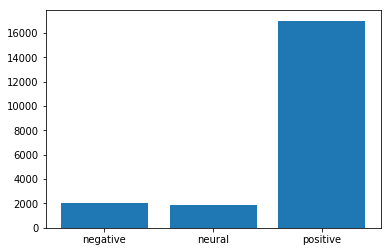

tổng số review: 20936


In [7]:
def plotData(inputJson):
    # load du lieuj Json
    fJson = open(inputJson, 'r')
    dataJson = json.loads(fJson.read())
    fJson.close()
    start = {
        'negative':0,
        'neural':0,
        'positive':0
    }
    sum_reviews = 0
    #chép dũ liệu
    for pd in dataJson:
        sum_reviews += pd['reviews count']
        for rv in pd['reviews']:
            if rv['review_rating'] == 1 or rv['review_rating'] == 0 :
                start['negative'] += 1
            elif rv['review_rating'] == 2 or rv['review_rating'] == 3:
                start['neural'] += 1
            else:
                start['positive'] += 1
    #tiến hành vẽ
    plt.bar(start.keys(), start.values(), align='center')
    plt.show()
    print("tổng số review: " + str(sum_reviews))

plotData('DulieuDaQuaTienXuLi.json')

### phân chia dữ liệu

cấu trúc file:

+preData:

+X

+---pos_data.txt

+---neg_data.txt

+---neur_data.txt

+Y

+---y.txt

---

train : validation

--80%-----20%------

---

+dùng

+---pos_data: 1500

+---neg_data: 1500

+---neur_data: 1500

+---total : 4500


### đọc các file dữ liệu và tóm tắt dữ liệu

In [8]:
def readData(pos, neur, neg, num):
    # đọc file
    pos_df = pd.read_csv(pos, names=['text'],encoding="utf-8");
    neur_df = pd.read_csv(neur, names=['text'],encoding="utf-8");
    neg_df = pd.read_csv(neg, names=['text'],encoding="utf-8");
    # gắn nhãn
    pos_df['label'] = 1;
    neur_df['label'] = 0;
    neg_df['label'] = -1;
    
    a = pos_df[:num]
    b = neur_df[:num]
    c = neg_df[:num]
    total = a.append(b)
    total = total.append(c)
    
    # tóm tắt dữ liệu
    return total

In [9]:
if __name__ == '__main__':
    ### crawl Data
    #ReadAsin('DuLieuTho.json')
    
    ### xử lí dữ liệu
    #preProcReviews('DuLieuTho.json', 'DulieuDaQuaTienXuLi.json')
    #devideData('DulieuDaQuaTienXuLi.json', 'pos_reviews.txt', 'neg_reviews.txt', 'neur_reviews.txt')
    
    ### load dữ liệu
    total_data = readData('pos_reviews.txt', 'neur_reviews.txt', 'neg_reviews.txt', 1800)
    #print(total_data)
    #print(total_data.groupby('label').describe())
    
    ### xây dựng model
    #convert review thành vector 
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(total_data['text'])
    X_train_counts.shape
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    X_train_tfidf.shape
    
    #phân chia dữ liệu
    text_train, text_test, label_train, label_test = train_test_split(total_data['text'], total_data['label'], test_size = 0.2)
    print(len(text_train), len(text_test), len(label_train), len(label_test))
    
    #khai báo pipeline
    pipeline_svm = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('classifier', SVC()),
    ])
    
    #
    param_svm = [
      {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
      {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
    ]
    
    #
    grid_svm = GridSearchCV(
        pipeline_svm, #fit dữ liệu
        param_grid=param_svm, 
        refit=True, 
        n_jobs=-1,  # chạy trên CPUs
        scoring='accuracy',
        cv=StratifiedKFold(label_train, n_folds=5),
    )
    
    %time classifier = grid_svm.fit(text_train, label_train)
    print(classifier.grid_scores_)
    
    # report
    
    ## download du lieu lan 2
    #ReadAsin('DuLieuTho1.json')
    #preProcReviews('DuLieuTho1.json', 'DulieuDaQuaTienXuLi1.json')
    
    ## download du lieu lan 3
    #ReadAsin('DuLieuTho2.json')
    #preProcReviews('DuLieuTho2.json', 'DulieuDaQuaTienXuLi2.json')

4320 1080 4320 1080
Wall time: 1min 56s
[mean: 0.73611, std: 0.00969, params: {'classifier__C': 1, 'classifier__kernel': 'linear'}, mean: 0.70486, std: 0.00948, params: {'classifier__C': 10, 'classifier__kernel': 'linear'}, mean: 0.67315, std: 0.01101, params: {'classifier__C': 100, 'classifier__kernel': 'linear'}, mean: 0.65509, std: 0.01226, params: {'classifier__C': 1000, 'classifier__kernel': 'linear'}, mean: 0.33565, std: 0.00035, params: {'classifier__C': 1, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}, mean: 0.33565, std: 0.00035, params: {'classifier__C': 1, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}, mean: 0.49884, std: 0.00792, params: {'classifier__C': 10, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}, mean: 0.33565, std: 0.00035, params: {'classifier__C': 10, 'classifier__gamma': 0.0001, 'classifier__kernel': 'rbf'}, mean: 0.73403, std: 0.01187, params: {'classifier__C': 100, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}, mea

### predict and result

In [14]:
print(classification_report(label_test, classifier.predict(text_test)))


             precision    recall  f1-score   support

         -1       0.68      0.73      0.71       350
          0       0.65      0.66      0.66       363
          1       0.91      0.83      0.87       367

avg / total       0.75      0.74      0.74      1080



In [16]:
print(classifier.predict(["I love this product"])[0])

1


In [24]:
print(classifier.predict(["everything say reason give 45 look high quality harden rubber rugged seem still price enough protection keep stylish"])[0])

0


In [23]:
print(classifier.predict(["honestly think great band like wide secure well use couple months though irritate skin like crazy think maybe user error try everything something material cause otherwise would give star stop usenow irritation get much"])[0])

0


In [21]:
print(classifier.predict(["use two month one band would stay lock"])[0])

-1


In [25]:
print(classifier.predict(["great product wife happy fit really good recommend everyone thank"])[0])


1


In [ ]:
Chuyển đổi review -> vector

Dùng CountVectorizer().fit(review).transformer(review) -> TfidfVectorizer().fit(review)->trandformer(review) -> vector_tfidf

Dùng SVM
 dùng GridSeachCV()


Pipeline
GridSearchCV
StratifiedKFold, cross_val_score, train_test_split 